## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Library

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import time

import random
random.seed(777)

## GPU Setting

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

print(f'Using PyTorch version: {torch.__version__} / Device: {device}')

Using PyTorch version: 1.8.1+cu101 / Device: cuda


## Hyperparameters

In [4]:
TRAINPATH = 'drive/MyDrive/Capstone-Design/dataset/AIHub/train' 
SAVEPATH = 'drive/MyDrive/Capstone-Design/model/AIHub_Aug/VGGNet'

LOADEPOCH = 91
ACC = 94

LR = 0.01
MOMENTUM = 0.9
WEIGHTDECAY = 5e-4

EPOCHS = 100
STEPSIZE = 30
GAMMA = 0.1

BATCHSIZE = 32

PRINTFREQ = 10

## Data Load

In [5]:
transfrom_train = transforms.Compose([
                            # transforms.RandomCrop(32, padding=4),
                            # transforms.RandomResizedCrop(224),
                            transforms.Resize(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(10),
                            transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                            ])

# transform_test = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(), 
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
# ])

train_dataset = torchvision.datasets.ImageFolder(root=TRAINPATH, transform=transfrom_train)

train_len = int((8/10) * len(train_dataset))
valid_len = len(train_dataset) - train_len

torch.manual_seed(777)
train_data, valid_data = torch.utils.data.dataset.random_split(train_dataset, [train_len, valid_len])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCHSIZE, shuffle=False, num_workers=2)

# test_data = torchvision.datasets.ImageFolder(root=TESTPATH, transform=transform_test)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCHSIZE, shuffle=False, num_workers=2)


classes = ('궤양병', '잎곰팡이병', '점무늬병', '황화잎말림바이러스', '아메리카잎굴파리', '청벌레', '정상')

In [6]:
print("train data:", len(train_data))
print("valid data:", len(valid_data))
# print("test data:", len(test_data))

train data: 11964
valid data: 2991


## Define Model

In [7]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        
        self.features = features # Convolution layer
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), # 크기 다를시 input 수정
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        ) # FC layer
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) # Convolution 
        x = self.avgpool(x) # avgpool
        x = x.view(x.size(0), -1) #
        x = self.classifier(x) # FC layer
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [8]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers)

In [9]:
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'custom' : [64,64,64,'M',128,128,128,'M',256,256,256,'M']
}

In [10]:
model = VGG(make_layers(cfg['D']), num_classes=7, init_weights=True)

## Load Model

In [11]:
if LOADEPOCH != 0:
  model.load_state_dict(torch.load(f'{SAVEPATH}/model_epoch_{LOADEPOCH}_acc_{ACC}.pth'))
  # model.eval()
  print(f'Load Model: model_epoch_{LOADEPOCH}_acc_{ACC}')
else:
  print('New Model')

Load Model: model_epoch_91_acc_94


## Train Model

In [12]:
model = model.to(device)

In [13]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHTDECAY)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=STEPSIZE, gamma=GAMMA)

In [14]:
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print(f'Accuracy of the network on the {len(valid_data)} test images: {acc:.2f} %')
    if save:
        torch.save(net.state_dict(), SAVEPATH + "/model_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

In [15]:
import time

In [16]:
start_time = time.time()
print('hi')
end_time = time.time()
print(f'{end_time - start_time:.4f}')

hi
0.0002


In [17]:
print(len(train_loader))
print('Start training')

valid_accuracy = []
valid_loss = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print(f"======================[Epoch {epoch+1:2d}]======================")
    start_time = time.time()
    running_loss = 0.0
    lr_sche.step()

    if epoch < LOADEPOCH:
      continue

    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i + 1) % PRINTFREQ == 0:
            # value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%3d, %4d] loss: %.3f' % (epoch+1, i+1, running_loss / PRINTFREQ))
            running_loss = 0.0
    
    #Check Accuracy
    end_time = time.time()
    print(f'{end_time - start_time:.4f}')
    acc = acc_check(model, valid_loader, epoch+1, save=1)
    valid_accuracy.append(acc)
    valid_loss.append(loss.item())

    # test_acc = acc_check(model, test_loader, epoch+1, save=0)
    # value_tracker(acc_plt, torch.Tensor([acc]), torch.Tensor([epoch]))
    

print('Finished Training')

374
Start training
======================[Epoch  1]======================
======================[Epoch  2]======================
======================[Epoch  3]======================
======================[Epoch  4]======================
======================[Epoch  5]======================
======================[Epoch  6]======================
======================[Epoch  7]======================
======================[Epoch  8]======================
======================[Epoch  9]======================
======================[Epoch 10]======================
======================[Epoch 11]======================
======================[Epoch 12]======================
======================[Epoch 13]======================
======================[Epoch 14]======================
======================[Epoch 15]======================
======================[Epoch 16]======================
======================[Epoch 17]======================
======================[Epoch 18]==============

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[ 92,   10] loss: 0.008
[ 92,   20] loss: 0.013
[ 92,   30] loss: 0.016
[ 92,   40] loss: 0.014
[ 92,   50] loss: 0.017
[ 92,   60] loss: 0.004
[ 92,   70] loss: 0.007
[ 92,   80] loss: 0.008
[ 92,   90] loss: 0.021
[ 92,  100] loss: 0.013
[ 92,  110] loss: 0.026
[ 92,  120] loss: 0.015
[ 92,  130] loss: 0.018
[ 92,  140] loss: 0.010
[ 92,  150] loss: 0.011
[ 92,  160] loss: 0.008
[ 92,  170] loss: 0.021
[ 92,  180] loss: 0.015
[ 92,  190] loss: 0.012
[ 92,  200] loss: 0.037
[ 92,  210] loss: 0.007
[ 92,  220] loss: 0.006
[ 92,  230] loss: 0.015
[ 92,  240] loss: 0.010
[ 92,  250] loss: 0.017
[ 92,  260] loss: 0.013
[ 92,  270] loss: 0.009
[ 92,  280] loss: 0.013
[ 92,  290] loss: 0.023
[ 92,  300] loss: 0.013
[ 92,  310] loss: 0.026
[ 92,  320] loss: 0.027
[ 92,  330] loss: 0.020
[ 92,  340] loss: 0.010
[ 92,  350] loss: 0.006
[ 92,  360] loss: 0.010
[ 92,  370] loss: 0.028
1248.1788
Accuracy of the network on the 2991 test images: 93.92 %
======================[Epoch 93]=============

## Test Model

ValueError: ignored

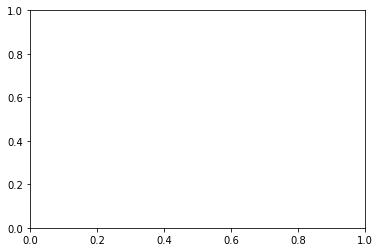

In [18]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 101)]

plt.plot(epochs, valid_accuracy)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.show()

In [ ]:
plt.plot(epochs, valid_loss)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.show()

In [19]:
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(7):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   궤양병 : 76 %
Accuracy of 잎곰팡이병 : 86 %
Accuracy of  점무늬병 : 95 %
Accuracy of 황화잎말림바이러스 : 77 %
Accuracy of 아메리카잎굴파리 : 93 %
Accuracy of   청벌레 : 43 %
Accuracy of    정상 : 97 %


In [20]:
correct = 0
total = 0

with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(valid_data)} test images: {(100 * correct)/total:.2f} %')

Accuracy of the network on the 2991 test images: 93.65 %


In [21]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

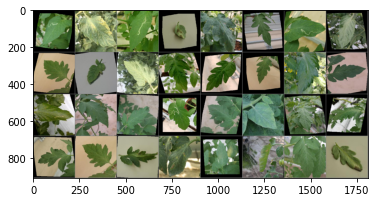

In [22]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

In [23]:
print('GroundTruth: \n', ' '.join('%5s \n' % classes[labels[j]] for j in range(32)))

GroundTruth: 
 아메리카잎굴파리 
    정상 
 아메리카잎굴파리 
 잎곰팡이병 
  점무늬병 
    정상 
 아메리카잎굴파리 
    정상 
    정상 
  점무늬병 
    정상 
    정상 
    정상 
    정상 
    정상 
    정상 
 아메리카잎굴파리 
    정상 
    정상 
 아메리카잎굴파리 
    정상 
 황화잎말림바이러스 
    정상 
    정상 
    정상 
    정상 
 잎곰팡이병 
  점무늬병 
 아메리카잎굴파리 
   궤양병 
    정상 
 잎곰팡이병 



In [24]:
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: \n', ' '.join('%5s \n' % classes[predicted[j]] for j in range(32)))

Predicted: 
 아메리카잎굴파리 
    정상 
 아메리카잎굴파리 
 잎곰팡이병 
  점무늬병 
    정상 
 아메리카잎굴파리 
    정상 
    정상 
  점무늬병 
    정상 
    정상 
    정상 
    정상 
 아메리카잎굴파리 
    정상 
 아메리카잎굴파리 
    정상 
    정상 
 아메리카잎굴파리 
    정상 
 황화잎말림바이러스 
    정상 
    정상 
    정상 
    정상 
 잎곰팡이병 
  점무늬병 
 아메리카잎굴파리 
  점무늬병 
    정상 
 잎곰팡이병 

